In [2]:
import pickle
import numpy as np
import seaborn as sns # ?????
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [142]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_labels.pickle', 'rb') as f:
    test_no_labels = pickle.load(f)

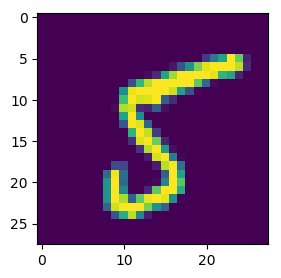

In [143]:
# Пример, как можно визуализировать данные
plt.figure(figsize=(3,3))
plt.style.use('default')

plt.imshow(train['data'][0].reshape(28,28))

# Обучаем модель

In [202]:
# Реализуйте здесь обучение модели
#plt.style.use('seaborn')
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_labels.pickle', 'rb') as f:
    test_no_labels = pickle.load(f)

x_train, y_train = train['data'], train['labels']
#x_test = test_no_lables['data']

def zero_one_normalize(x):
    for i,pixel in enumerate(x):
        x[i] = pixel/(128)
    return x

def z_score_normalize(x):
    for i in range(x.shape[0]):
        mean = np.mean(x[i], axis=0)
        std = np.std(x[i], axis=0)
        x[i] = (x[i] - mean)/std
    return x

y_train[y_train==6] = 1
y_train[y_train==5] = 0
x_train = zero_one_normalize(x_train)
#x_train = z_score_normalize(x_train)

In [203]:
print(x_train[0][:].reshape(28,28))
print(y_train)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 

In [189]:
# добавляем единичную колонку для w0
x_train = np.hstack([ np.ones((x_train.shape[0], 1)), x_train] )

In [200]:
# Инициализируем веса случайны образом
np.random.seed(11)
w = np.random.normal(scale=0.001, size = x_train.shape[1])

In [201]:
for iter in tqdm.tqdm_notebook(range(100)):
    for i in range(x_train.shape[0]):
        j = np.random.randint(0, x_train.shape[0])
        grad = - y_train[j] * x_train[j] / \
            ( 1 + math.exp( x_train[j] * np.dot(w.T, x_train[j]) ) ) + 0 * w
        w = w - 0.01 * grad

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
xx, yy = np.meshgrid(np.linspace(0, rx, 28), np.linspace(0, rx, 28))
Z = np.vstack([np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]).T
p = (1. / (1. + np.exp(-np.dot(Z, w)))).reshape(xx.shape)
    
print(p)

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

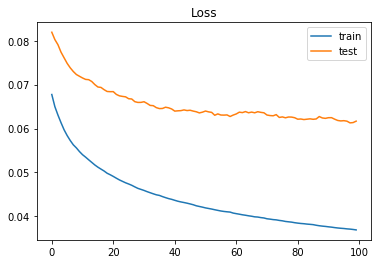

In [219]:
plt.title('Loss')
plt.plot([e[0] for e in tr_eval], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

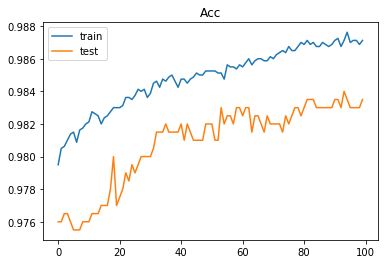

In [220]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [221]:
X = test_no_lables['data']

# compute Y_pred

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test['labels'])):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb